# Tutorial01
> Created Aug. 2024 for the FSU Course: *Machine Learning in Physics* <br>
> Updated Aug. 2025: use mlinphysics module
> Harrison B. Prosper<br>


## Introduction

In this tutorial, we build a simple classifier, $f(\boldsymbol{x}, \boldsymbol{\omega})$, to classify the points in a 2D Gaussian dataset. 

The best-fit values of the parameters of our classifier will be found by  minimizing a quantity that is analogous to a **least squares** objective function. The quantity to be minimized is called the **empirical risk** $R(\omega)$, where the  **quadratic loss** function $[y - f(\boldsymbol{x}, \boldsymbol{\omega})]^2$ in the least squares fit, which measures the descrepancy between the **target** $y$ and the function $f$, is replaced by the **binary cross-entropy loss**. That loss function is typically used to build a binary (that is, 2-class) classifier.

The binary cross-entropy loss is defined by 

$$L(y, f) = - [y \log f + (1 - y) \log(1-f)],$$ 

with the discrete targets $y \in \{0, 1\}$. In Lecture 2, it will be shown that the best-fit function $f(\boldsymbol{x}, \widehat{\boldsymbol{\omega}})$ approximates the solution to the equation
\begin{align*}
\int \, \frac{\partial L(y, f)}{\partial f} \, p(y | \boldsymbol{x}) \, dy & = 0,
\end{align*}
where $L(y, f)$ can be any (piece-wise) differentiable loss function.

From
\begin{align*}
0 & = \int \, \frac{\partial L(y, f)}{\partial f} \, p(y | \boldsymbol{x}) \, dy, \quad \text{ we see that}\\
    & = \int \,  \left( \frac{y}{f} - \frac{(1 - y)}{1-f}  \right) p(y | \boldsymbol{x}) \, dy,\\
    & = \frac{p(y=1 | \boldsymbol{x})}{f} - \frac{p(y=0 | \boldsymbol{x})}{1 -f},\\
   \frac{f}{1-f} & = \frac{p(y=1 | \boldsymbol{x})}{p(y=0 | \boldsymbol{x})},\quad \implies f  = p(y=1 | \boldsymbol{x}) .
\end{align*}
We conclude that our classifier approximates the conditional probability $p(y=1 | \boldsymbol{x})$. This conclusion is independent of the details of the model $f(\boldsymbol{x}, \boldsymbol{\omega})$.

In [1]:
# standard system modules
import os, sys, re

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard statistical module
import scipy.stats as st

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
#%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

import mlinphysics.nn as ml
import mlinphysics.utils.data as md
import mlinphysics.utils.lossmonitor as lm

import importlib

# update fonts
FONTSIZE = 12
plt.rcParams.update({
    "text.usetex": True, # turn OFF if the system can't find LaTex!
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": FONTSIZE
})

# set a seed to ensure reproducibility
#seed = 128
#rnd  = np.random.RandomState(seed)

## Constants

In [2]:
DATA_FILE  = '../data/two2dnormals.csv'
  
CONFIG = 'gauss2d'

# choose whether to create or load a config file
load_existing_config = False

if load_existing_config:
    CONFIG = f'{CONFIG}.json'
    
TRAIN_SIZE = 80_000
VAL_SIZE   =  5_000
TEST_SIZE  = 15_000

N_STEPS = 2           # number of steps with fixed learning rate
N_ITERS_PER_STEP = 25_000
N_ITERS = N_ITERS_PER_STEP * N_STEPS

BATCH_SIZE = 128
BASE_LR = 1.e-3       # initial learning rate
GAMMA = 0.5           # learning rate scale factor
MONITOR_STEPS = 100   # monitor training every 10 iterations

TARGET = 'target'
FEATURES = ['x1', 'x2']

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


## Configuration

In [3]:
# Create configuration object
# -----------------------------------------
config = ml.Config(CONFIG)

# Training configuration
# -----------------------------------------
batch_size = config('batch_size', BATCH_SIZE)
val_size   = config('val_size', VAL_SIZE)         # validation sample size
n_iterations_per_step = config('n_iters_per_step', N_ITERS_PER_STEP)
monitor_every_n_iterations = config('monitor_step', MONITOR_STEPS)

# Optimizer / scheduler configuration
# -----------------------------------------
n_steps  = config('n_steps', N_STEPS)              # Number of training steps

n_iterations = N_ITERS
base_lr  = config('base_lr', BASE_LR)             # Initial LR
gamma    = config('gamma', GAMMA)                 # LR scale factor

print(f'\nSave configuration to file {config.cfg_filename}\n')
config.save()
print(config)


Save configuration to file gauss2d_config.json

{
    "name": "gauss2d",
    "file": {
        "losses": "gauss2d_losses.csv",
        "params": "gauss2d_params.pth",
        "initparams": "gauss2d_init_params.pth"
    },
    "batch_size": 128,
    "val_size": 5000,
    "n_iters_per_step": 25000,
    "monitor_step": 100,
    "n_steps": 2,
    "base_lr": 0.001,
    "gamma": 0.5
}


## Exact density

Use the `%%writefile` command to write the cell contents to a file. The contents of file can be imported into another notebook providing a simple way to share code betweeen notebooks.

In [4]:
%%writefile exactdensity.py
import numpy as np
import scipy.stats as st

class ExactDensity:
    def __init__(self):
        self.rv1 = st.multivariate_normal(mean=[0.25, -0.25], 
                                          cov=[[0.20, 0.24], 
                                               [0.24, 0.40]])
        
        self.rv2 = st.multivariate_normal(mean=[-0.10, 0.10], 
                                          cov=[[0.60, 0.40], 
                                               [0.40, 0.30]])

    def grid(self, xmin=-1, xmax=1, ymin=-1, ymax=1, N=100):
        xstep = (xmax-xmin)/N
        ystep = (ymax-ymin)/N
        x1, x2 = np.mgrid[xmin:xmax+xstep/2:xstep, ymin:ymax+ystep/2:ystep]
        return x1, x2
        
    def __call__(self, x1, x2):
        # compute density at a grid of (x1, x2) points
        pos= np.dstack((x1, x2)) 
        p1 = self.rv1.pdf(pos)
        p0 = self.rv2.pdf(pos)
        return (p1 + p0)/2

    def prob(self, x1, x2):
        # compute p(y=1|x) at a grid of (x1, x2) points
        pos= np.dstack((x1, x2))
        p1 = self.rv1.pdf(pos)
        p0 = self.rv2.pdf(pos)
        return p1 / (p1 + p0)

Overwriting exactdensity.py


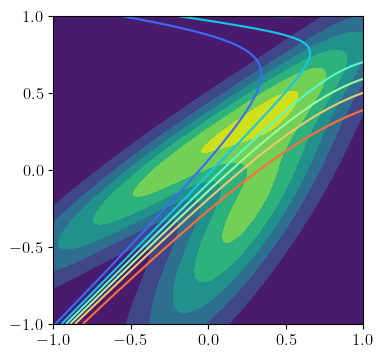

In [5]:
from exactdensity import ExactDensity

fexact = ExactDensity()
x1, x2 = fexact.grid()

fig = plt.figure(figsize=(4, 4))
ax  = fig.add_subplot(111)

tickmarks = [-1.0, -0.5, 0.0, 0.5, 1.0]
ax.set_xticks(tickmarks)
ax.set_yticks(tickmarks)

ax.contourf(x1, x2, fexact(x1, x2))
ax.contour(x1, x2, fexact.prob(x1, x2), cmap='rainbow')
plt.show()

## Load raw data

In [6]:
df = pd.read_csv(DATA_FILE)
print(len(df))
df[:10]

100000


,x1,x2,target
0,-0.665786,-0.574222,0.0
1,-0.213577,-0.173010,0.0
2,0.236111,-0.723421,1.0
3,0.160948,0.490774,0.0
4,-0.355925,-0.615319,1.0
5,0.695868,0.483321,1.0
6,-0.039668,0.265816,0.0
7,0.079798,0.062791,0.0
8,-2.130000,-1.338907,0.0
9,0.163297,0.088248,0.0


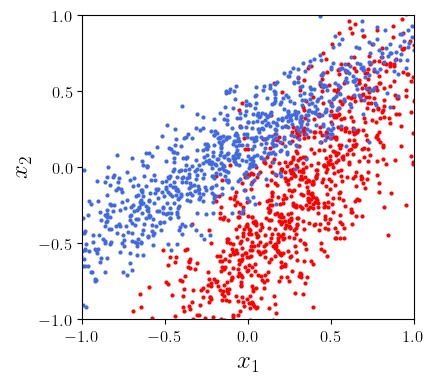

In [7]:
def plot_data():
    
    fig = plt.figure(figsize=(4.5, 4))
    
    ax  = fig.add_subplot(111)
    
    tickmarks = [-1.0, -0.5, 0.0, 0.5, 1.0]
    
    ax.set_xlim(-1, 1)
    ax.set_xlabel(r'$x_1$', fontsize=18)
    ax.set_xticks(tickmarks)
    
    ax.set_ylim(-1, 1)
    ax.set_ylabel(r'$x_2$', fontsize=18)
    ax.set_yticks(tickmarks)
    
    d1 = df[df.target > 0.5]
    xp, yp = d1.x1[:1000], d1.x2[:1000]
    ax.scatter(xp, yp, s=4.0, color='red')
    
    d2 = df[df.target < 0.5]
    xp, yp = d2.x1[:1000], d2.x2[:1000]
    ax.scatter(xp, yp, s=4.0, color='royalblue');
    
    fig.tight_layout()
    
    plt.show()

plot_data()

## Create Datasets

Split data into inputs $\boldsymbol{x}$ and targets $y$.

In [8]:
importlib.reload(md)

# convert to numpy array
data = df.to_numpy()
data.shape

train_data = md.Dataset(data, 
                        start=0, 
                        end=TRAIN_SIZE, 
                        split_data=2) # [0,1], [2]

train_data_val = md.Dataset(data, 
                            start=0, 
                            end=TRAIN_SIZE,
                            random_sample_size=VAL_SIZE,
                            split_data=2) # [0,1], [2]

val_data = md.Dataset(data, 
                      start=TRAIN_SIZE, 
                      end=TRAIN_SIZE + VAL_SIZE,
                      split_data=2)

test_data= md.Dataset(data, 
                      start=TRAIN_SIZE + VAL_SIZE, 
                      end=TRAIN_SIZE + VAL_SIZE + TEST_SIZE,
                      split_data=2)

Dataset
  shape of x: torch.Size([80000, 2])
  shape of y: torch.Size([80000, 1])

Dataset
  shape of x: torch.Size([5000, 2])
  shape of y: torch.Size([5000, 1])

Dataset
  shape of x: torch.Size([5000, 2])
  shape of y: torch.Size([5000, 1])

Dataset
  shape of x: torch.Size([15000, 2])
  shape of y: torch.Size([15000, 1])



## Save test data

In [9]:
import joblib
joblib.dump(test_data, 'test_data.pth')

['test_data.pth']

## Create DataLoaders

In [10]:
train_loader = md.DataLoader(train_data, 
                             batch_size=BATCH_SIZE,
                             num_iterations=N_ITERS)

train_loader_val = md.DataLoader(train_data_val, 
                                 batch_size=len(train_data_val))

val_loader = md.DataLoader(val_data, 
                           batch_size=len(val_data))

DataLoader
  Maximum number of iterations has been specified
  maxiter:           50000
  batch_size:          128
  shuffle_step:        625

DataLoader
  maxiter:               1
  batch_size:         5000
  shuffle_step:          1

DataLoader
  maxiter:               1
  batch_size:         5000
  shuffle_step:          1



## Some ML Utilities

In [12]:
# Note: there are several average loss functions available 
# in PyTorch, such as nn.CrossEntropyLoss(), but it's useful 
# to know how to create your own.
def average_quadratic_loss(f, y):
    # f and t must be of the same shape
    losses = (f - y)**2
    return torch.mean(losses)

def average_binary_cross_entropy_loss(f, y):
    # f and t must be of the same shape
    # Note: because of our use of the "where" function, the 
    # precise values of the targets doesn't matter so long as for
    # one class y < 0.5 and the other y > 0.5
    losses = -torch.where(y > 0.5, torch.log(f), torch.log(1 - f))
    return torch.mean(losses)
        
def validate(model, avloss, x, y):
    # set to evaluation mode so that any training 
    # specific operations are disabled.
    model.eval()
    with torch.no_grad(): # no need to compute gradients wrt. x and y
        # reshape to ensure that f and y are of the same shape!
        f = model(x).reshape(y.shape)
    return avloss(f, y)

def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_loss_curve(losses):
    
    xx, yy_t, yy_v = losses
    
    # create an empty figure
    fig = plt.figure(figsize=(6, 4))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    ax.plot(xx, yy_t, color='red',  lw=1, label='training loss')
    ax.plot(xx, yy_v, color='blue', lw=1, label='validation loss')
    ax.legend()
    
    ax.set_xlabel('iterations', fontsize=FONTSIZE)
    ax.set_ylabel('average loss', fontsize=FONTSIZE)
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    
    fig.tight_layout()
    
    plt.show()

## Define a fully-connected neural network

### $\texttt{SiLU}(x)$

$$\text{silu}(x) = x \, \sigma(x), \text{where } \sigma(x) \text{ is the logistic.}$$


### LayerNorm

$$y = \frac{(x - E[x])}{\sqrt{V(x)}},$$

where the averaging is over the layer.

In [13]:
%%writefile gauss2d.py
import torch.nn as nn
H = 15
model = nn.Sequential(nn.Linear(2, H), nn.SiLU(), nn.LayerNorm(H),
                      nn.Linear(H, H), nn.SiLU(), nn.LayerNorm(H),
                      nn.Linear(H, H), nn.SiLU(), nn.LayerNorm(H),
                      nn.Linear(H, 1), nn.Sigmoid())

Overwriting gauss2d.py


## Train model

In [14]:
from gauss2d import model

print('Model architecture\n')
print(model)
print(f'number of parameters: {ml.number_of_parameters(model)}')
print()

importlib.reload(ml)

optimizer = torch.optim.Adam(model.parameters(), lr=BASE_LR) 

scheduler = ml.get_steplr_scheduler(optimizer, config)

emprisk   = average_binary_cross_entropy_loss

Model architecture

Sequential(
  (0): Linear(in_features=2, out_features=15, bias=True)
  (1): SiLU()
  (2): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=15, out_features=15, bias=True)
  (4): SiLU()
  (5): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (6): Linear(in_features=15, out_features=15, bias=True)
  (7): SiLU()
  (8): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (9): Linear(in_features=15, out_features=1, bias=True)
  (10): Sigmoid()
)
number of parameters: 631

number of milestones:          1

Step | Milestone | LR
-----------------------------
   0 |         0 | 1.0e-03   
-----------------------------
   1 |     25000 | 5.0e-04   

number of iterations:          50000



In [15]:
importlib.reload(ml)
importlib.reload(lm)
importlib.reload(md)

def train(model, emprisk, optimizer, scheduler, 
          train_loader, train_small_loader, val_loader,
          config):

    # get configuration info
    
    lossfile     = config('file/losses')
    paramsfile   = config('file/params')
    
    timeleftfile = config('file/timeleft', 'timeleft.txt')
    step         = config('monitor_step', 100)
    delete       = config('delete', True)
    frac         = config('frac', 0.015)

    # instantiate object that saves average losses to a csv file 
    # for realtime monitoring

    number_iterations = len(train_loader)
    
    losswriter = lm.LossWriter(number_iterations, 
                               lossfile, timeleftfile, 
                               step=step, 
                               frac=frac, 
                               delete=delete,
                               model=model, 
                               paramsfile=paramsfile) 
    
    # training loop
    
    current_lr = -1.0

    def objective(x, y):
        f = model(x)          # compute model output
        return emprisk(f, y)  # compute average loss

    for ii, (x, y) in enumerate(train_loader):

        # set mode to training so that training-specific 
        # operations such as dropout, etc., are enabled.
        model.train()

        # clear all gradients
        optimizer.zero_grad()
        
        av_loss = objective(x, y)

        # compute gradients
        av_loss.backward()

        # take one step downhill in the average loss landscape
        optimizer.step()
            
        scheduler.step()
        
        # i'm alive printout
        if (ii % step == 0) or (ii == number_iterations-1):

            model.eval() # go into evaluation mode
            
            t_loss = ml.compute_avg_loss(objective, train_small_loader)
            
            v_loss = ml.compute_avg_loss(objective, val_loader)

            # update loss file

            lr = optimizer.param_groups[0]['lr']

            if lr != current_lr:
                current_lr = lr
                print()
                print(f'\t\tlearning rate: {lr:10.3e}')
                
            losswriter(ii, t_loss, v_loss, lr)


		learning rate:  5.000e-04
     50000|100.00%|00:00:45/00:00:00|1104.4 it/s|       50000| 2.521e-01| 2.547e-01|


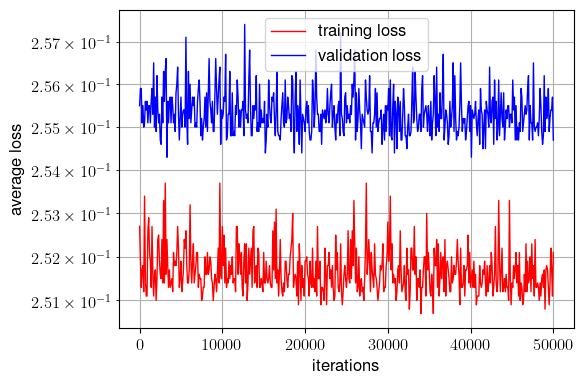

In [17]:
train(model, emprisk, optimizer, scheduler, 
          train_loader, train_loader_val, val_loader,
          config)

losses = lm.get_losses(config('file/losses'))
plot_loss_curve(losses)